In [5]:
import kagglehub
import os

# Download dataset
path = kagglehub.dataset_download("jutrera/stanford-car-dataset-by-classes-folder")
print("Dataset path:", path)

# Explore folders
print(os.listdir(path))


Using Colab cache for faster access to the 'stanford-car-dataset-by-classes-folder' dataset.
Dataset path: /kaggle/input/stanford-car-dataset-by-classes-folder
['names.csv', 'car_data', 'anno_test.csv', 'anno_train.csv']


In [6]:
for root, dirs, files in os.walk(path):
    if any(f.endswith(".jpg") for f in files):
        print("Images found in:", root)
        break


Images found in: /kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010


In [7]:
base_path = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data"

train_path = base_path + "/train"
test_path  = base_path + "/test"

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset  = datasets.ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))
print("Classes:", len(train_dataset.classes))


Train samples: 8144
Test samples: 8041
Classes: 196


In [9]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


In [14]:
model = resnet18(weights="IMAGENET1K_V1")

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Train only last layer
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)

optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)


In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

In [16]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [18]:
model = resnet18(weights="IMAGENET1K_V1")

# فكي التجميد — لازم!!!
for param in model.parameters():
    param.requires_grad = True

# عددي آخر طبقة حسب عدد الكلاسات
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)


In [19]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3)


In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
])


In [21]:
def train(model, train_loader, optimizer, scheduler, criterion, epochs=3):
    model.train()

    for epoch in range(epochs):
        correct = 0
        total = 0
        running_loss = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            running_loss += loss.item()

            pbar.set_postfix({
                "loss": running_loss / total,
                "acc": 100 * correct / total
            })

        scheduler.step()
        print(f"\n🔥 Epoch {epoch+1} Accuracy: {100*correct/total:.2f}%\n")

    return model

trained_model = train(model, train_loader, optimizer, scheduler, criterion, epochs=3)


Epoch 1/3: 100%|██████████| 255/255 [01:26<00:00,  2.96it/s, loss=0.129, acc=20.6]



🔥 Epoch 1 Accuracy: 20.60%



Epoch 2/3: 100%|██████████| 255/255 [01:27<00:00,  2.92it/s, loss=0.066, acc=73.2]



🔥 Epoch 2 Accuracy: 73.18%



Epoch 3/3: 100%|██████████| 255/255 [01:26<00:00,  2.94it/s, loss=0.0394, acc=95.8]


🔥 Epoch 3 Accuracy: 95.75%



In [22]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    acc = 100 * correct / total
    print(f"✅ Test Accuracy: {acc:.2f}%")

evaluate(trained_model, test_loader)


✅ Test Accuracy: 76.97%


In [23]:
import matplotlib.pyplot as plt
from PIL import Image

# mapping من index إلى اسم الكلاس
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}


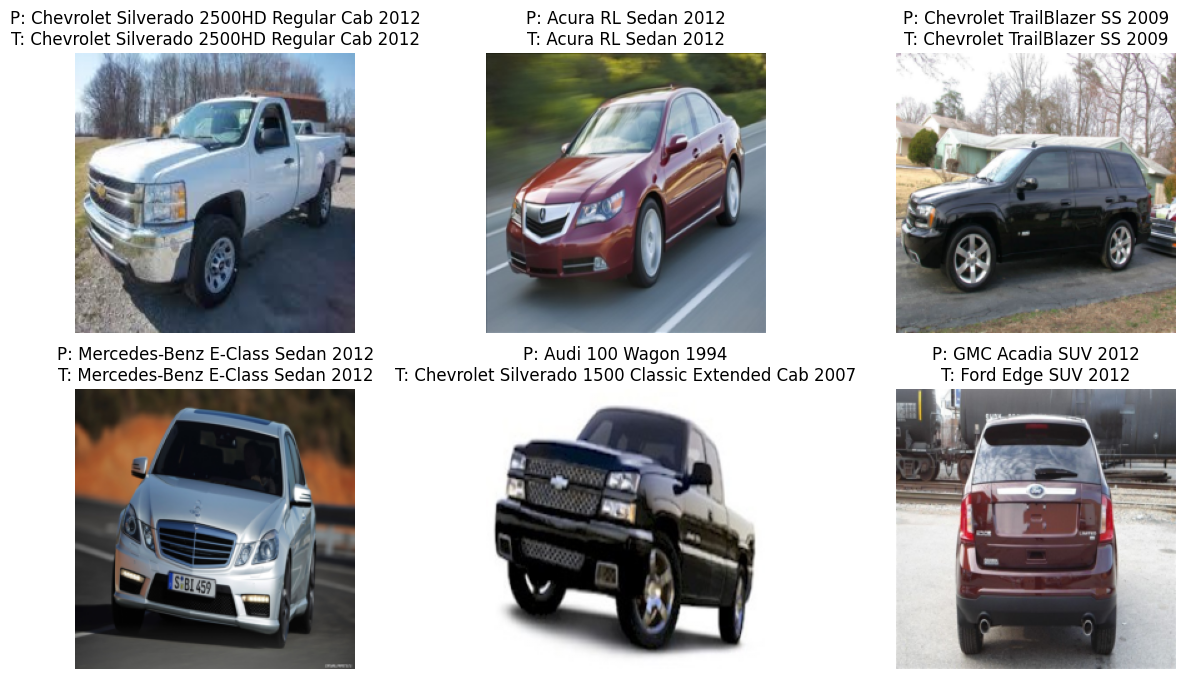

In [34]:
model.eval()

plt.figure(figsize=(15, 8))
for i, (img, label) in enumerate(picked):
    img_tensor = img.unsqueeze(0).to(device)
    output = model(img_tensor)
    pred = torch.argmax(output, 1).item()

    plt.subplot(2, 3, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"P: {classes[pred]}\nT: {classes[label]}")
    plt.axis("off")

plt.show()


In [35]:
import torch

torch.save(trained_model.state_dict(), "resnet18_train95.pth")
print("Model saved!")


Model saved!
